In [10]:
import torch
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [11]:
df_train = pd.read_csv("../../data/ml-100k/ub.base", sep="\t", 
                 header=None, names=['user id', 'item id', 'rating', 'timestamp'])

df_test = pd.read_csv("../../data/ml-100k/ub.test", sep="\t", 
                 header=None, names=['user id', 'item id', 'rating', 'timestamp'])

In [12]:
# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [38]:
user_movies_train = (
    pd.pivot(data=df_train, index='user id', columns='item id', values='rating')
)

# creating tensor from user movies matrix
scaler = StandardScaler().fit(user_movies_train)
#train_tensor = torch.tensor(scaler.transform(user_movies_train))
train_tensor = torch.tensor(user_movies_train.values)

# DataLoader is used to load the dataset
# for training
train_loader = torch.utils.data.DataLoader(dataset = train_tensor,
                                     batch_size = 32,
                                     shuffle = True)

train_tensor.shape

torch.Size([943, 1675])

In [39]:
filled_train_tensor = torch.nan_to_num(train_tensor).float().to(device)

In [40]:
user_movies_test = (
    pd.pivot(data=df_test, index='user id', columns='item id', values='rating')
)

In [41]:
cols_train_not_in_test = user_movies_train.columns[
    ~user_movies_train.columns.isin(user_movies_test.columns)]

cols_test_not_in_train = user_movies_test.columns[
    ~user_movies_test.columns.isin(user_movies_train.columns)]

len(cols_train_not_in_test), len(cols_test_not_in_train)

(537, 7)

In [42]:
extra_cols = pd.DataFrame(
    index=user_movies_test.index,
    columns=cols_train_not_in_test
)

In [43]:
extra_user_movies_test = (
    pd.concat([user_movies_test, extra_cols], axis=1)
    .drop(cols_test_not_in_train, axis=1)
)
extra_user_movies_test = extra_user_movies_test.reindex(
    sorted(extra_user_movies_test.columns), axis=1
)

#extra_user_movies_test = scaler.transform(extra_user_movies_test)

In [45]:
test_mask = ~torch.tensor(extra_user_movies_test.values.astype(float)).isnan().to(device)
test_ground_truth = torch.nan_to_num(torch.tensor(extra_user_movies_test.values.astype(float))).to(device)

In [46]:
n_movies = train_tensor[0].shape[0]
n_movies

1675

In [79]:
# Creating a PyTorch class
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(n_movies, 200),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 20),
        )
    
    
        self.decoder = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Linear(20, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 200),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(200, n_movies),
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [112]:
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
model = AE().to(device)
epochs=300
# Model Initialization
optimizer = torch.optim.Adam(model.parameters(), 
                             lr = 1e-4,
                             weight_decay = 1e-8)
epoch_loss_train = []
epoch_loss_test = []
for epoch in tqdm(range(epochs)):
    train_loss = 0

            ## TRAIN MODEL ##
    # Put model in train mode
    model.train()

    # Loop through data loader data batches
    for batch, (X) in enumerate(train_loader):
        
        # Send data to target device
        X = X.float().to(device)
        batch_mask = ~torch.isnan(X).flatten()
        X = torch.nan_to_num(X)
        # 1. Forward pass
        X_pred = model(X).flatten()[batch_mask]
        # 2. Calculate  and accumulate loss
        loss = loss_function(X_pred, X.flatten()[batch_mask])
        train_loss += loss.item()
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        
    test_error = []
    with torch.inference_mode():
        preds = model(filled_train_tensor)
        preds = torch.clip(preds, 1, 5)
        test_error = loss_function(preds.flatten()[test_mask.flatten()],
                                                   test_ground_truth.flatten()[test_mask.flatten()]).item()

    epoch_loss_train += [train_loss / len(train_loader)]
    epoch_loss_test += [test_error]

  0%|          | 0/300 [00:00<?, ?it/s]

In [109]:
print(preds.min()), print(preds.max())

tensor(1., device='cuda:0')
tensor(5., device='cuda:0')


(None, None)

In [110]:
print(min(epoch_loss_test))

0.9908814465860158


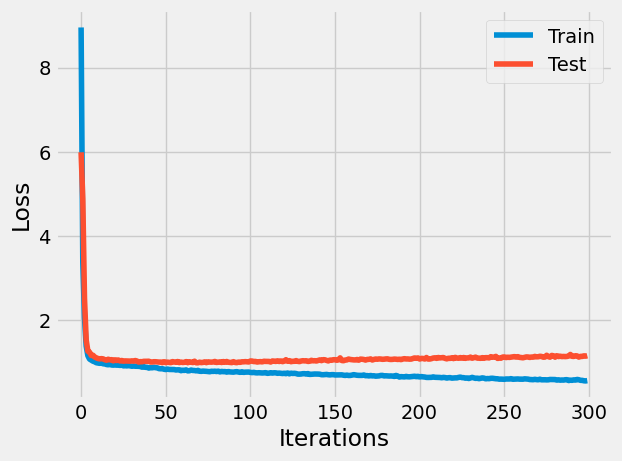

In [111]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
plt.plot(epoch_loss_train, label='Train')
plt.plot(epoch_loss_test, label='Test')
plt.legend()


In [17]:
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
epochs=500
# Model Initialization
model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), 
                             lr = 1e-4,
                             weight_decay = 1e-8)

epoch_loss_train = []
epoch_loss_test = []
for epoch in tqdm(range(epochs)):
    train_loss = 0

            ## TRAIN MODEL ##
    # Put model in train mode
    model.train()

    # Loop through data loader data batches
    for batch, (X) in enumerate(train_loader):
        
        # Send data to target device
        X = X.float().to(device)
        batch_mask = ~torch.isnan(X)
        X = torch.nan_to_num(X)
        noise = torch.tensor(np.array([np.random.normal(loc=0,
                                                        scale=.2,
                                                        size=X.shape[1])
                  for i in range(X.shape[0])])).to(device)
        X_noise = (X + noise).float().to(device) * batch_mask
        # 1. Forward pass
        X_pred = model(X_noise) * batch_mask
        # 2. Calculate  and accumulate loss
        loss = loss_function(X_pred, X)
        train_loss += loss.item()
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        
    test_error = []
    with torch.inference_mode():
        preds = model(filled_train_tensor)
        preds = scaler.inverse_transform(preds.cpu()).flatten()
        np.clip(preds, a_min=1, a_max=5, out=preds)
        test_error += [mean_squared_error(preds[test_mask], 
                                          test_ground_truth[test_mask], squared=False)]

    epoch_loss_train += [train_loss / len(train_loader)]
    epoch_loss_test += [test_error]

  0%|          | 0/500 [00:00<?, ?it/s]

In [18]:
print(min(epoch_loss_test))

[0.9927707978768341]


In [19]:
print(max(epoch_loss_test[-20:]))

[1.0017931953303012]


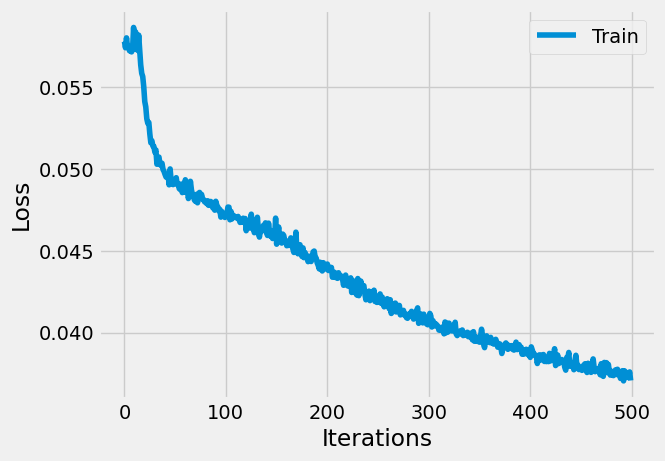

In [22]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
plt.plot(epoch_loss_train, label='Train')
#plt.plot(epoch_loss_test, label='Test')
plt.legend()


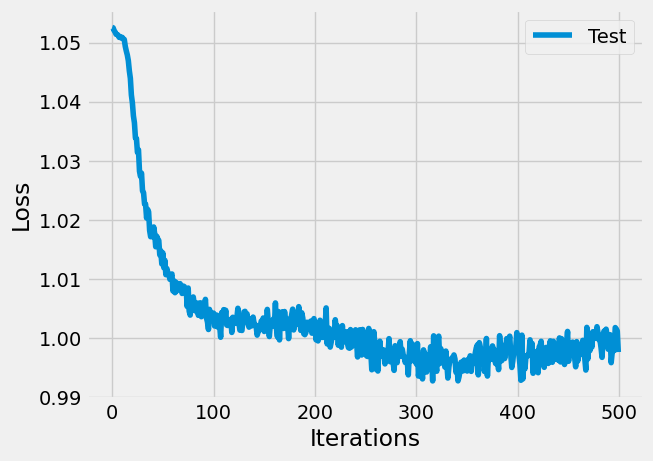

In [23]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
#plt.plot(epoch_loss_train, label='Train')
plt.plot(epoch_loss_test, label='Test')
plt.legend()
